# Using Convolutional to Identify Clothes

I built a LeNet-5 convolutional network and trained it on the FashionMNIST dataset using my train_loader and val_loader. I experimented with different hyperparameters to optimize performance and achieved a validation accuracy of at least 0.8.

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim



In [2]:
manualSeed = 42
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  42


Let's download the [`FashionMNIST`](https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)dataset and visualize example images from it.

In [4]:
batch_size = 64
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
train_set = torchvision.datasets.FashionMNIST(root='FashionMNIST', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_set = torchvision.datasets.FashionMNIST(root='FashionMNIST', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.42MB/s]


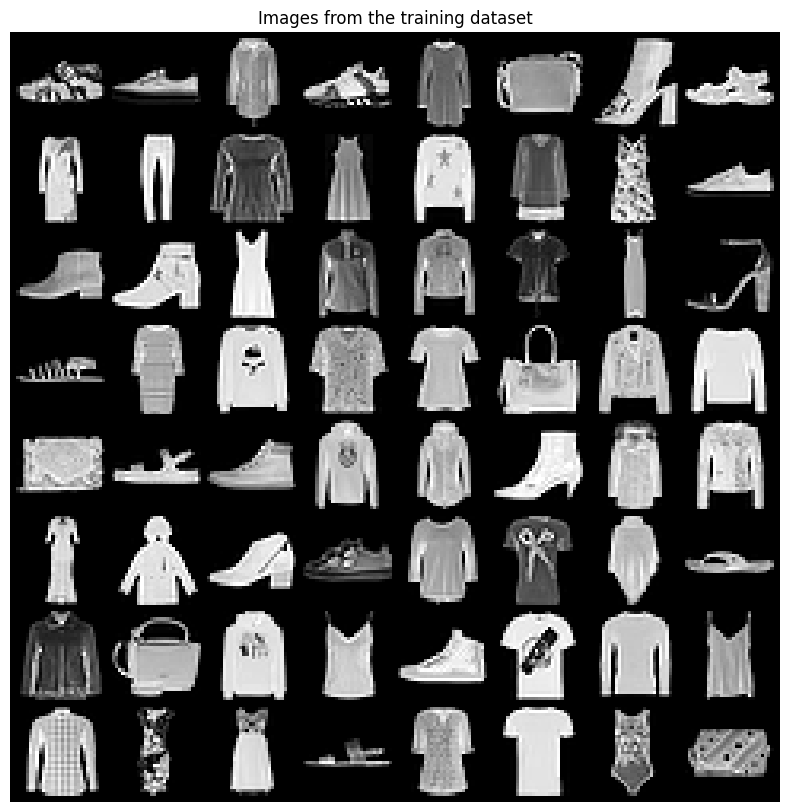

In [5]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

real_batch = next(iter(train_loader))

device = "cuda:0"

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Images from the training dataset")
plt.show()

In [6]:
train_loader

In [8]:
# Number of samples in each dataset
print("Training set size:", len(train_set))
print("Validation set size:", len(val_set))

# Number of iterations (batches) per epoch
print("Batches per training epoch:", len(train_loader))
print("Batches per validation epoch:", len(val_loader))


Training set size: 60000
Validation set size: 10000
Batches per training epoch: 938
Batches per validation epoch: 157


## LeNet-5 Model Definition

In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)     # 1x28x28 → 6x24x24
        self.pool = nn.AvgPool2d(2, stride=2)           # 6x24x24 → 6x12x12
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)    # 6x12x12 → 16x8x8

        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 4 * 4)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


## Model Training and Evaluation Functions

In [9]:

def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    model.to(device)

    # Initialize lists to store metrics
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        # Calculate metrics for this epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / len(train_loader.dataset)
        epoch_val_acc = evaluate_model(model, val_loader, device)


        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, "
              f"Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f}")

    return train_losses, train_accuracies, val_accuracies

def evaluate_model(model, loader, device):
    model.eval()
    correct = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    return correct / len(loader.dataset)








## Model Initialization, Training, and Accuracy Plotting

In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = LeNet5()
criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model1.parameters(), lr=0.001)


train_losses1, train_accs1, val_accs1 =train_model(model1, criterion, optimizer, train_loader, val_loader, device, epochs=20)


Epoch [1/20], Loss: 0.6202, Train Acc: 0.7725, Val Acc: 0.8206
Epoch [2/20], Loss: 0.4180, Train Acc: 0.8475, Val Acc: 0.8472
Epoch [3/20], Loss: 0.3666, Train Acc: 0.8673, Val Acc: 0.8514
Epoch [4/20], Loss: 0.3410, Train Acc: 0.8748, Val Acc: 0.8648
Epoch [5/20], Loss: 0.3205, Train Acc: 0.8828, Val Acc: 0.8609
Epoch [6/20], Loss: 0.3053, Train Acc: 0.8880, Val Acc: 0.8669
Epoch [7/20], Loss: 0.2886, Train Acc: 0.8942, Val Acc: 0.8704
Epoch [8/20], Loss: 0.2754, Train Acc: 0.8988, Val Acc: 0.8800
Epoch [9/20], Loss: 0.2638, Train Acc: 0.9019, Val Acc: 0.8807
Epoch [10/20], Loss: 0.2542, Train Acc: 0.9052, Val Acc: 0.8810
Epoch [11/20], Loss: 0.2433, Train Acc: 0.9103, Val Acc: 0.8853
Epoch [12/20], Loss: 0.2346, Train Acc: 0.9130, Val Acc: 0.8863
Epoch [13/20], Loss: 0.2266, Train Acc: 0.9159, Val Acc: 0.8881
Epoch [14/20], Loss: 0.2178, Train Acc: 0.9178, Val Acc: 0.8871
Epoch [15/20], Loss: 0.2100, Train Acc: 0.9222, Val Acc: 0.8872
Epoch [16/20], Loss: 0.2012, Train Acc: 0.9258, V

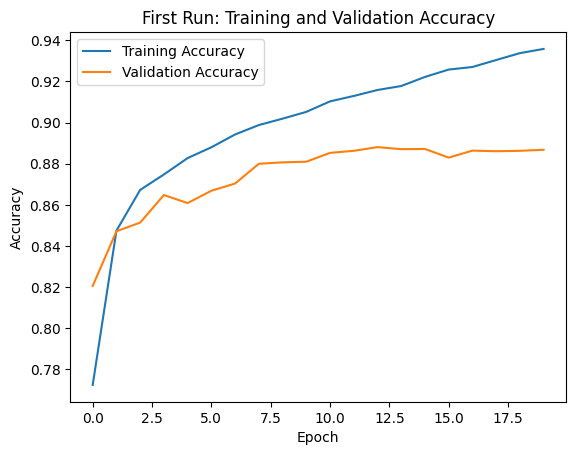

In [12]:
plt.plot(train_accs1, label='Training Accuracy')
plt.plot(val_accs1, label='Validation Accuracy')
plt.title('First Run: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

After completing 20 epochs of training, achieving a loss of 0.1678, a training accuracy of 93.75%, and a validation accuracy of 89.14%, I explored various LeNet-5 configurations to further optimize performance on the FashionMNIST dataset. I experimented with the number of convolutional layers, activation functions (Tanh and ReLU), pooling methods (average and max), and different filter sizes and counts. This process allowed me to identify the configuration that achieved the highest validation accuracy.

The idea here is to test two variables at a time and use the best one until I get accuracy scores above 90%

In [13]:


class LeNet5(nn.Module):
    def __init__(self, num_conv_layers=2, activation='Tanh', pooling='Avg', filter_size=5, num_filters=[6, 16]):
        super(LeNet5, self).__init__()

        self.activation_fn = nn.Tanh() if activation == 'Tanh' else nn.ReLU()
        self.pool_fn = nn.AvgPool2d(2, stride=2) if pooling == 'Avg' else nn.MaxPool2d(2, stride=2)

        # First convolution layer
        self.conv1 = nn.Conv2d(1, num_filters[0], kernel_size=filter_size)

        if num_conv_layers == 2:
            # Second convolution layer
            self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], kernel_size=filter_size)
            self.use_two_conv = True

            # Calculate the output size after convolutions and pooling
            conv_output_size = self._get_conv_output_size(filter_size, 2)
            fc_input_dim = num_filters[1] * conv_output_size * conv_output_size
        else:
            self.use_two_conv = False
            conv_output_size = self._get_conv_output_size(filter_size, 1)
            fc_input_dim = num_filters[0] * conv_output_size * conv_output_size

        # Fully connected layers
        self.fc1 = nn.Linear(fc_input_dim, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def _get_conv_output_size(self, filter_size, conv_layers):
        size = 28  # input image size
        for _ in range(conv_layers):
            size = size - filter_size + 1  # after conv
            size = size // 2               # after pooling
        return size

    def forward(self, x):
        x = self.activation_fn(self.conv1(x))
        x = self.pool_fn(x)

        if self.use_two_conv:
            x = self.activation_fn(self.conv2(x))
            x = self.pool_fn(x)

        x = x.view(x.size(0), -1)
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        x = self.fc3(x)
        return x


In Model 2, I increased the convolution layers and then evaluated the model’s accuracy. Adding more convolution layers allows the network to learn more complex and hierarchical features, where early layers detect simple patterns and deeper layers capture higher-level structures.

In [14]:
model2 = LeNet5(
    num_conv_layers=2,
    activation='ReLU',
    pooling='Max',
    filter_size=5,
    num_filters=[6, 16]
)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2
criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model2.parameters(), lr=0.001)


train_losses2, train_accs2, val_accs2 = train_model(model2, criterion, optimizer, train_loader, val_loader, device, epochs=20)

Epoch [1/20], Loss: 0.6134, Train Acc: 0.7716, Val Acc: 0.8302
Epoch [2/20], Loss: 0.4011, Train Acc: 0.8528, Val Acc: 0.8604
Epoch [3/20], Loss: 0.3485, Train Acc: 0.8723, Val Acc: 0.8656
Epoch [4/20], Loss: 0.3201, Train Acc: 0.8810, Val Acc: 0.8713
Epoch [5/20], Loss: 0.2945, Train Acc: 0.8918, Val Acc: 0.8767
Epoch [6/20], Loss: 0.2788, Train Acc: 0.8969, Val Acc: 0.8838
Epoch [7/20], Loss: 0.2633, Train Acc: 0.9017, Val Acc: 0.8884
Epoch [8/20], Loss: 0.2507, Train Acc: 0.9065, Val Acc: 0.8848
Epoch [9/20], Loss: 0.2390, Train Acc: 0.9099, Val Acc: 0.8886
Epoch [10/20], Loss: 0.2293, Train Acc: 0.9144, Val Acc: 0.8889
Epoch [11/20], Loss: 0.2202, Train Acc: 0.9183, Val Acc: 0.8948
Epoch [12/20], Loss: 0.2118, Train Acc: 0.9198, Val Acc: 0.8922
Epoch [13/20], Loss: 0.2034, Train Acc: 0.9247, Val Acc: 0.8907
Epoch [14/20], Loss: 0.1951, Train Acc: 0.9272, Val Acc: 0.8932
Epoch [15/20], Loss: 0.1874, Train Acc: 0.9284, Val Acc: 0.8903
Epoch [16/20], Loss: 0.1832, Train Acc: 0.9296, V

Comparing Model 1 and Moel 2

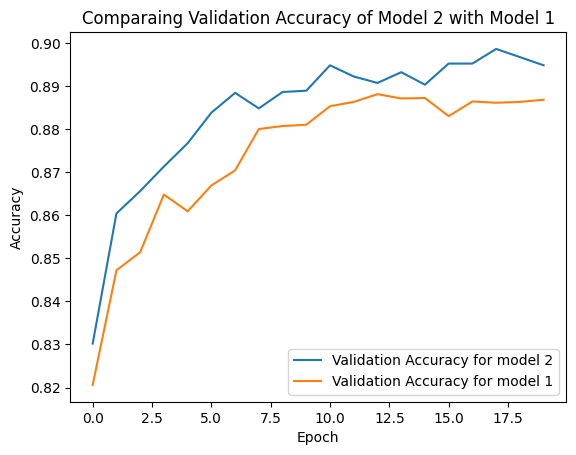

In [18]:

plt.plot(val_accs2, label='Validation Accuracy for model 2')
plt.plot(val_accs1, label='Validation Accuracy for model 1')
plt.title('Comparaing Validation Accuracy of Model 2 with Model 1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In Model 3, I used average pooling instead of max pooling and then evaluated the model’s accuracy. Pooling is a technique used in neural networks, particularly convolutional neural networks (CNNs), to reduce the spatial dimensions (height and width) of feature maps while retaining important information. This helps make the model more efficient and less prone to overfitting. Max pooling selects the maximum value from a region of the feature map, highlighting the most prominent features, while average pooling computes the average value of the region, capturing the general presence of features rather than only the strongest signals. By switching from max to average pooling, the model emphasizes overall feature presence, which can influence accuracy depending on the data.

In [19]:
model3 = LeNet5(
    num_conv_layers=2,
    activation='ReLU',
    pooling='Average',
    filter_size=5,
    num_filters=[6, 16]
)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model3.parameters(), lr=0.001)


train_losses3, train_accs3, val_accs3 = train_model(model3, criterion, optimizer, train_loader, val_loader, device, epochs=20)

Epoch [1/20], Loss: 0.6288, Train Acc: 0.7658, Val Acc: 0.8228
Epoch [2/20], Loss: 0.4086, Train Acc: 0.8490, Val Acc: 0.8497
Epoch [3/20], Loss: 0.3563, Train Acc: 0.8693, Val Acc: 0.8531
Epoch [4/20], Loss: 0.3222, Train Acc: 0.8813, Val Acc: 0.8752
Epoch [5/20], Loss: 0.3005, Train Acc: 0.8891, Val Acc: 0.8724
Epoch [6/20], Loss: 0.2830, Train Acc: 0.8951, Val Acc: 0.8775
Epoch [7/20], Loss: 0.2677, Train Acc: 0.8997, Val Acc: 0.8858
Epoch [8/20], Loss: 0.2568, Train Acc: 0.9041, Val Acc: 0.8916
Epoch [9/20], Loss: 0.2429, Train Acc: 0.9092, Val Acc: 0.8795
Epoch [10/20], Loss: 0.2332, Train Acc: 0.9122, Val Acc: 0.8878
Epoch [11/20], Loss: 0.2228, Train Acc: 0.9157, Val Acc: 0.8946
Epoch [12/20], Loss: 0.2146, Train Acc: 0.9198, Val Acc: 0.8909
Epoch [13/20], Loss: 0.2070, Train Acc: 0.9213, Val Acc: 0.8951
Epoch [14/20], Loss: 0.1977, Train Acc: 0.9254, Val Acc: 0.8905
Epoch [15/20], Loss: 0.1897, Train Acc: 0.9290, Val Acc: 0.8983
Epoch [16/20], Loss: 0.1834, Train Acc: 0.9295, V

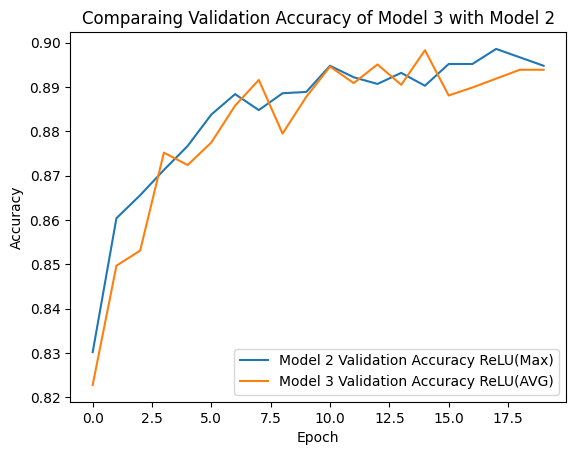

In [22]:
plt.plot(val_accs2, label='Model 2 Validation Accuracy ReLU(Max)')
plt.plot(val_accs3, label='Model 3 Validation Accuracy ReLU(AVG)')
plt.title('Comparaing Validation Accuracy of Model 3 with Model 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Since Relu with average pooling did well, I decided to use it again but with more convolution layers. This time I doubled things.  

In [23]:
model4 = LeNet5(
    num_conv_layers=4,
    activation='ReLU',
    pooling='Average',
    filter_size=5,
    num_filters=[6, 16]
)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model4.parameters(), lr=0.001)


train_losses4, train_accs4, val_accs4 = train_model(model4, criterion, optimizer, train_loader, val_loader, device, epochs=20)

Epoch [1/20], Loss: 0.5119, Train Acc: 0.8164, Val Acc: 0.8557
Epoch [2/20], Loss: 0.3405, Train Acc: 0.8772, Val Acc: 0.8745
Epoch [3/20], Loss: 0.2969, Train Acc: 0.8907, Val Acc: 0.8886
Epoch [4/20], Loss: 0.2661, Train Acc: 0.9015, Val Acc: 0.8892
Epoch [5/20], Loss: 0.2447, Train Acc: 0.9101, Val Acc: 0.8945
Epoch [6/20], Loss: 0.2253, Train Acc: 0.9159, Val Acc: 0.8998
Epoch [7/20], Loss: 0.2112, Train Acc: 0.9200, Val Acc: 0.8985
Epoch [8/20], Loss: 0.1942, Train Acc: 0.9266, Val Acc: 0.9012
Epoch [9/20], Loss: 0.1805, Train Acc: 0.9320, Val Acc: 0.9006
Epoch [10/20], Loss: 0.1669, Train Acc: 0.9375, Val Acc: 0.9049
Epoch [11/20], Loss: 0.1561, Train Acc: 0.9411, Val Acc: 0.8997
Epoch [12/20], Loss: 0.1449, Train Acc: 0.9458, Val Acc: 0.9042
Epoch [13/20], Loss: 0.1384, Train Acc: 0.9469, Val Acc: 0.9009
Epoch [14/20], Loss: 0.1279, Train Acc: 0.9510, Val Acc: 0.9035
Epoch [15/20], Loss: 0.1174, Train Acc: 0.9554, Val Acc: 0.9032
Epoch [16/20], Loss: 0.1117, Train Acc: 0.9565, V

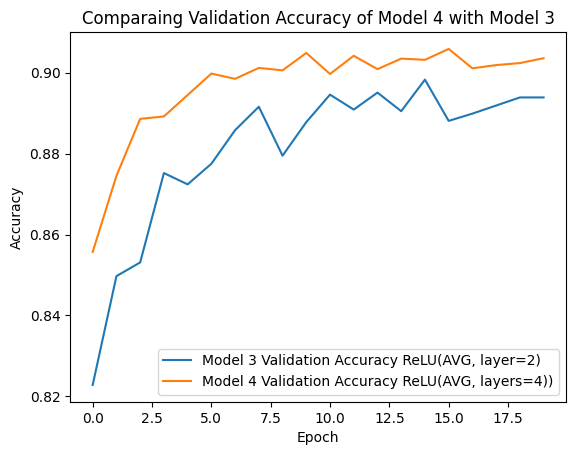

In [25]:
plt.plot(val_accs3, label='Model 3 Validation Accuracy ReLU(AVG, layer=2)')
plt.plot(val_accs4, label='Model 4 Validation Accuracy ReLU(AVG, layers=4))')
plt.title('Comparaing Validation Accuracy of Model 4 with Model 3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Increasng the number of layers made the model much better!

In Model 5, I plan to increase the number of filters in the convolution layers and then evaluate the model’s accuracy. Filters, also called kernels, are used in convolution layers to extract different features from the input data. By increasing the number of filters, the network can capture a greater variety of features at each layer, potentially improving its ability to recognize patterns.

In [26]:
model5 = LeNet5(
    num_conv_layers=4,
    activation='ReLU',
    pooling='Average',
    filter_size=5,
    num_filters=[8, 18]
)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model5.parameters(), lr=0.001)


train_losses5, train_accs5, val_accs5 = train_model(model5, criterion, optimizer, train_loader, val_loader, device, epochs=20)

Epoch [1/20], Loss: 0.4898, Train Acc: 0.8253, Val Acc: 0.8593
Epoch [2/20], Loss: 0.3285, Train Acc: 0.8819, Val Acc: 0.8766
Epoch [3/20], Loss: 0.2856, Train Acc: 0.8957, Val Acc: 0.8895
Epoch [4/20], Loss: 0.2562, Train Acc: 0.9052, Val Acc: 0.8943
Epoch [5/20], Loss: 0.2342, Train Acc: 0.9131, Val Acc: 0.8950
Epoch [6/20], Loss: 0.2139, Train Acc: 0.9206, Val Acc: 0.9058
Epoch [7/20], Loss: 0.1989, Train Acc: 0.9259, Val Acc: 0.9039
Epoch [8/20], Loss: 0.1801, Train Acc: 0.9336, Val Acc: 0.9050
Epoch [9/20], Loss: 0.1679, Train Acc: 0.9368, Val Acc: 0.9074
Epoch [10/20], Loss: 0.1542, Train Acc: 0.9418, Val Acc: 0.9060
Epoch [11/20], Loss: 0.1407, Train Acc: 0.9463, Val Acc: 0.9054
Epoch [12/20], Loss: 0.1293, Train Acc: 0.9513, Val Acc: 0.9014
Epoch [13/20], Loss: 0.1185, Train Acc: 0.9555, Val Acc: 0.9078
Epoch [14/20], Loss: 0.1095, Train Acc: 0.9584, Val Acc: 0.9068
Epoch [15/20], Loss: 0.1014, Train Acc: 0.9610, Val Acc: 0.9057
Epoch [16/20], Loss: 0.0941, Train Acc: 0.9639, V

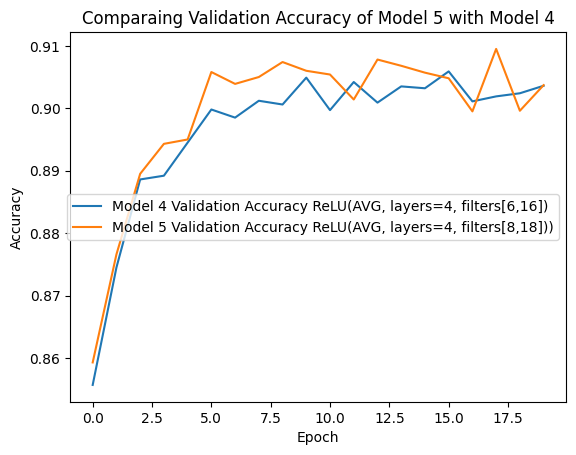

In [29]:
plt.plot(val_accs4, label='Model 4 Validation Accuracy ReLU(AVG, layers=4, filters[6,16])')
plt.plot(val_accs5, label='Model 5 Validation Accuracy ReLU(AVG, layers=4, filters[8,18]))')
plt.title('Comparaing Validation Accuracy of Model 5 with Model 4')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The difference is not so much but model 5 seems a bit better so we use it for the next experiement

 Instead of using ReLU as the activation function, I decided to use TanH, while keeping the other parameters the same. Activation functions introduce non-linearity into the network, allowing it to learn complex patterns. ReLU outputs zero for negative inputs and the input itself for positive values, which often speeds up training but can cause some neurons to “die” if they stop activating. TanH, on the other hand, outputs values between -1 and 1, centering the data and potentially improving learning for certain datasets.

In [30]:
model6 = LeNet5(
    num_conv_layers=4,
    activation='Tanh',
    pooling='Average',
    filter_size=5,
    num_filters=[8, 18]
)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model6.parameters(), lr=0.001)


train_losses6, train_accs6, val_accs6 = train_model(model6, criterion, optimizer, train_loader, val_loader, device, epochs=20)

Epoch [1/20], Loss: 0.4558, Train Acc: 0.8410, Val Acc: 0.8767
Epoch [2/20], Loss: 0.3069, Train Acc: 0.8886, Val Acc: 0.8894
Epoch [3/20], Loss: 0.2607, Train Acc: 0.9051, Val Acc: 0.8904
Epoch [4/20], Loss: 0.2282, Train Acc: 0.9168, Val Acc: 0.8943
Epoch [5/20], Loss: 0.2021, Train Acc: 0.9257, Val Acc: 0.9002
Epoch [6/20], Loss: 0.1780, Train Acc: 0.9342, Val Acc: 0.8985
Epoch [7/20], Loss: 0.1567, Train Acc: 0.9417, Val Acc: 0.9002
Epoch [8/20], Loss: 0.1396, Train Acc: 0.9495, Val Acc: 0.9024
Epoch [9/20], Loss: 0.1227, Train Acc: 0.9555, Val Acc: 0.9006
Epoch [10/20], Loss: 0.1067, Train Acc: 0.9611, Val Acc: 0.8952
Epoch [11/20], Loss: 0.0942, Train Acc: 0.9665, Val Acc: 0.8998
Epoch [12/20], Loss: 0.0814, Train Acc: 0.9709, Val Acc: 0.9025
Epoch [13/20], Loss: 0.0720, Train Acc: 0.9746, Val Acc: 0.8993
Epoch [14/20], Loss: 0.0659, Train Acc: 0.9763, Val Acc: 0.9012
Epoch [15/20], Loss: 0.0567, Train Acc: 0.9800, Val Acc: 0.9001
Epoch [16/20], Loss: 0.0524, Train Acc: 0.9806, V

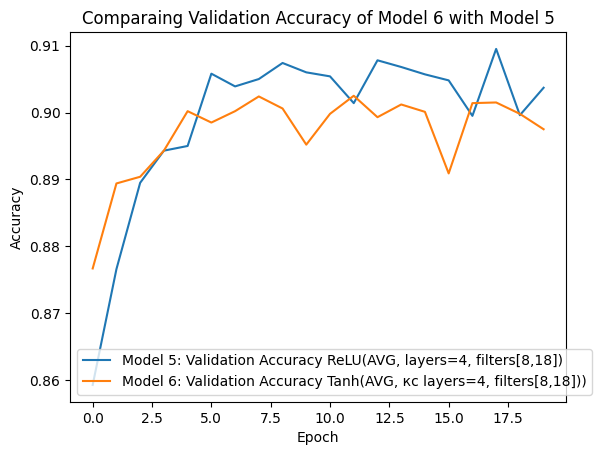

In [33]:
plt.plot(val_accs5, label='Model 5: Validation Accuracy ReLU(AVG, layers=4, filters[8,18])')
plt.plot(val_accs6, label='Model 6: Validation Accuracy Tanh(AVG, кс layers=4, filters[8,18]))')
plt.title('Comparaing Validation Accuracy of Model 6 with Model 5')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In the previous experiment, ReLU outperformed TanH as the activation function. In this experiment, I decided to use max pooling and set the number of filters in the convolution layers to 6 and 16 and compare it with ReLu's best (model 5)

In [34]:
model7 = LeNet5(
    num_conv_layers=4,
    activation='Tanh',
    pooling='Max',
    filter_size=5,
    num_filters=[6, 16]
)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model7.parameters(), lr=0.001)


train_losses7, train_accs7, val_accs7 = train_model(model7, criterion, optimizer, train_loader, val_loader, device, epochs=20)

Epoch [1/20], Loss: 0.4789, Train Acc: 0.8311, Val Acc: 0.8712
Epoch [2/20], Loss: 0.3157, Train Acc: 0.8859, Val Acc: 0.8817
Epoch [3/20], Loss: 0.2743, Train Acc: 0.8998, Val Acc: 0.8820
Epoch [4/20], Loss: 0.2430, Train Acc: 0.9107, Val Acc: 0.8936
Epoch [5/20], Loss: 0.2179, Train Acc: 0.9194, Val Acc: 0.8895
Epoch [6/20], Loss: 0.1982, Train Acc: 0.9270, Val Acc: 0.9014
Epoch [7/20], Loss: 0.1778, Train Acc: 0.9343, Val Acc: 0.9007
Epoch [8/20], Loss: 0.1608, Train Acc: 0.9407, Val Acc: 0.8984
Epoch [9/20], Loss: 0.1443, Train Acc: 0.9473, Val Acc: 0.9036
Epoch [10/20], Loss: 0.1306, Train Acc: 0.9525, Val Acc: 0.9030
Epoch [11/20], Loss: 0.1160, Train Acc: 0.9572, Val Acc: 0.8975
Epoch [12/20], Loss: 0.1055, Train Acc: 0.9619, Val Acc: 0.8996
Epoch [13/20], Loss: 0.0927, Train Acc: 0.9658, Val Acc: 0.9010
Epoch [14/20], Loss: 0.0853, Train Acc: 0.9689, Val Acc: 0.8959
Epoch [15/20], Loss: 0.0744, Train Acc: 0.9732, Val Acc: 0.9003
Epoch [16/20], Loss: 0.0692, Train Acc: 0.9752, V

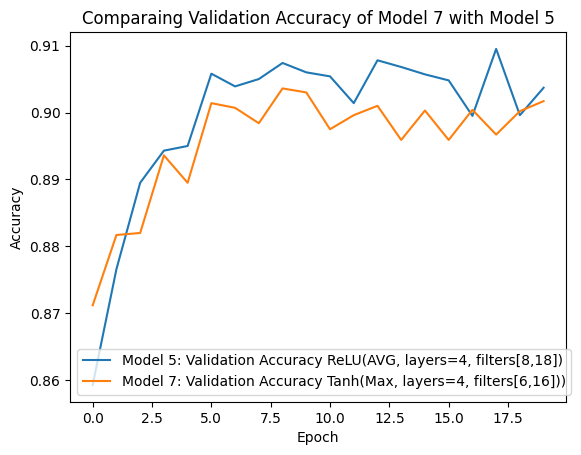

In [36]:
plt.plot(val_accs5, label='Model 5: Validation Accuracy ReLU(AVG, layers=4, filters[8,18])')
plt.plot(val_accs7, label='Model 7: Validation Accuracy Tanh(Max, layers=4, filters[6,16]))')
plt.title('Comparaing Validation Accuracy of Model 7 with Model 5')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [43]:
import pandas as pd

In [44]:
configs = [
    "num_conv_layers=1, activation=ReLU, pooling=Max, filter_size=5, num_filters=[6, 16]",
    "num_conv_layers=2, activation=ReLU, pooling=Max, filter_size=5, num_filters=[6, 16]",
    "num_conv_layers=2, activation=ReLU, pooling=Average, filter_size=5, num_filters=[6, 16]",
    "num_conv_layers=4, activation=ReLU, pooling=Average, filter_size=5, num_filters=[6, 16]",
    "num_conv_layers=4, activation=ReLU, pooling=Average, filter_size=5, num_filters=[8, 18]",
    "num_conv_layers=4, activation=Tanh, pooling=Average, filter_size=5, num_filters=[8, 18]",
    "num_conv_layers=4, activation=Tanh, pooling=Max, filter_size=5, num_filters=[6, 16]"
]


val_acc_dict = [val_accs1, val_accs2, val_accs3, val_accs4, val_accs5, val_accs6, val_accs7]


results_df = pd.DataFrame({
    "Model": [f"Model {i+1}" for i in range(7)],
    "Configuration": configs,
    "Final Validation Accuracy": [accs[-1] for accs in val_acc_dict]
})



# Results

In [45]:
results_df

,Model,Configuration,Final Validation Accuracy
0,Model 1,"num_conv_layers=1, activation=ReLU, pooling=Ma...",0.8868
1,Model 2,"num_conv_layers=2, activation=ReLU, pooling=Ma...",0.8948
2,Model 3,"num_conv_layers=2, activation=ReLU, pooling=Av...",0.8939
3,Model 4,"num_conv_layers=4, activation=ReLU, pooling=Av...",0.9036
4,Model 5,"num_conv_layers=4, activation=ReLU, pooling=Av...",0.9037
5,Model 6,"num_conv_layers=4, activation=Tanh, pooling=Av...",0.8975
6,Model 7,"num_conv_layers=4, activation=Tanh, pooling=Ma...",0.9017


# Conclusion

Among the experiments conducted, Model 5, configured as a LeNet-5 with 4 convolution layers, ReLU activation, average pooling, a filter size of 5, and 8 and 18 filters in the convolution layers, achieved the best performance. After 20 epochs, the model reached a training accuracy of 97.52% and a validation accuracy of 90.37%, with a loss of 0.0657. These results indicate that increasing the number of convolution layers and filters, combined with ReLU activation and average pooling, allowed the network to effectively capture complex features while maintaining strong generalization on the validation set.
